**Importing all dependencies**

In [3]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier       
from sklearn.ensemble import RandomForestClassifier     
import xgboost as xgb

**Setting up for chart styling**

In [7]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

**Loading the Data and Cleaning it**

In [10]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [14]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
#Converting the TotalCharges column to numeric
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [20]:
#Dropping the CustomerID column, because it is not much needed for this project
df.drop("customerID", axis=1, inplace=True)

In [22]:
# Encoding categorical features
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

**In the above section, I ensured that all features are numerical so that the models can use them. And the missing values in TotalCharges column were filled with the median**

**Exploratory Data Analysis (EDA)** | 
***Churn Distribution***

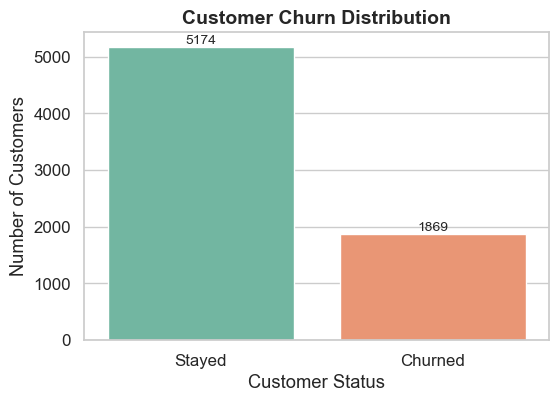

In [57]:
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df, hue="Churn", palette="Set2", legend=False)
plt.xticks([0, 1], ["Stayed", "Churned"])
plt.title("Customer Churn Distribution", fontsize=14, weight="bold")
plt.ylabel("Number of Customers")
plt.xlabel("Customer Status")

#Adding counts on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10)

plt.show()

**Tenure vs Churn**

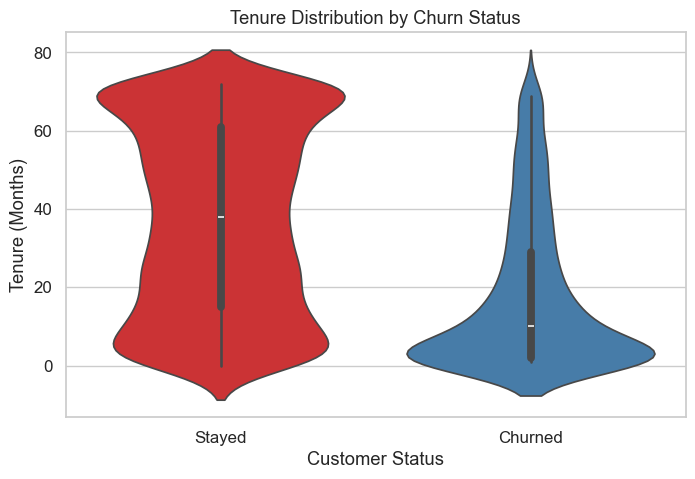

In [55]:
plt.figure(figsize=(8,5))
sns.violinplot(x="Churn", y="tenure", data=df, hue="Churn", palette="Set1",legend=False)
plt.xticks([0, 1], ["Stayed", "Churned"])
plt.title("Tenure Distribution by Churn Status")
plt.ylabel("Tenure (Months)")
plt.xlabel("Customer Status")
plt.show()

**Contract Type vs Churn**

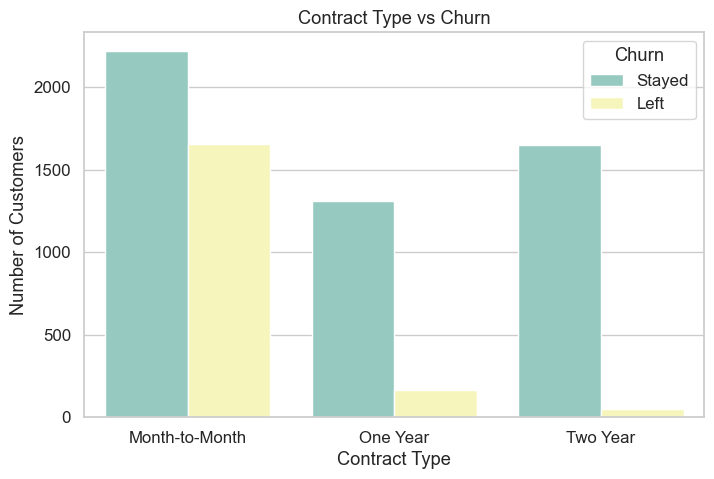

In [51]:
#Map numeric contract codes to labels
contract_map = {
    0: "Month-to-Month",
    1: "One Year",
    2: "Two Year"
}
df["Contract"] = df["Contract"].map(contract_map)

plt.figure(figsize=(8,5))
sns.countplot(x="Contract", hue="Churn", data=df, palette="Set3")
plt.title("Contract Type vs Churn")
plt.xlabel("Contract Type")
plt.ylabel("Number of Customers")
plt.legend(title="Churn", labels=["Stayed", "Left"])  
plt.show()

**Correlation Heatmap**

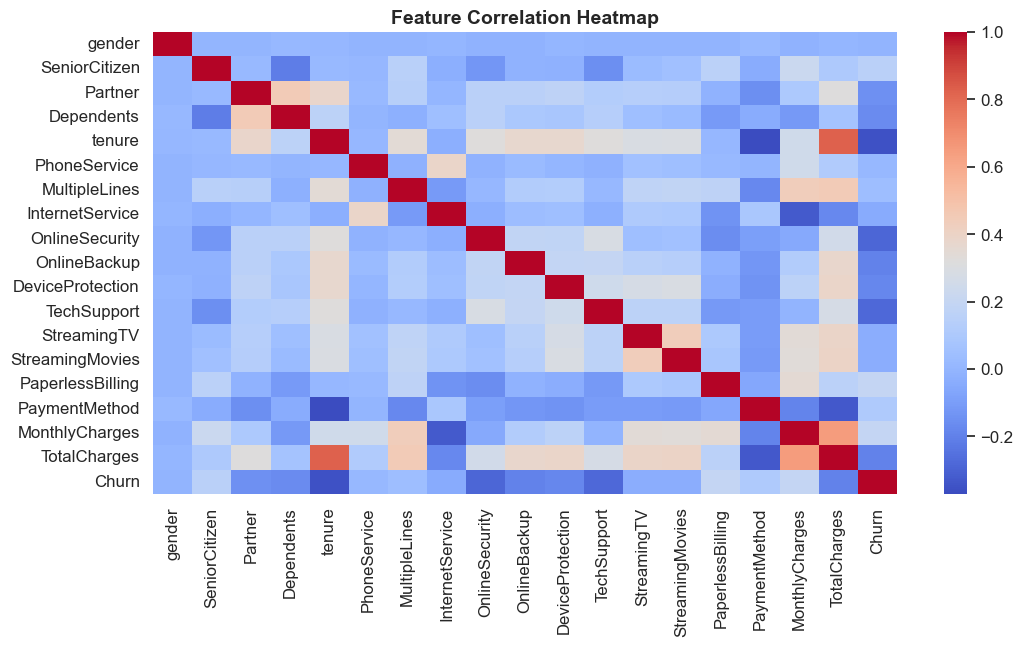

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_df = df.select_dtypes(include="number")

plt.figure(figsize=(12,6))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap", fontsize=14, weight="bold")
plt.show()


**Modeling**

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Training the Models**

In [85]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss") 
}

y_preds, y_probs = {}, {}

for name, model in models.items():
    
    X_train_model = X_train_scaled if name=="Logistic Regression" else X_train
    X_test_model = X_test_scaled if name=="Logistic Regression" else X_test

    model.fit(X_train_model, y_train)
    y_preds[name] = model.predict(X_test_model)
    y_probs[name] = model.predict_proba(X_test_model)[:,1]

**Evaluating**

***The Table can be used to compare models at a glance. For business decisions, focusung  on Recall & ROC-AUC.***

In [86]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_list = []

for name in models:
    metrics_list.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_preds[name]),
        "Precision": precision_score(y_test, y_preds[name]),
        "Recall": recall_score(y_test, y_preds[name]),
        "F1": f1_score(y_test, y_preds[name]),
        "ROC-AUC": roc_auc_score(y_test, y_probs[name])
    })

metrics_df = pd.DataFrame(metrics_list)
metrics_df


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,0.798439,0.640625,0.548128,0.590778,0.840244
1,Decision Tree,0.709013,0.451872,0.451872,0.451872,0.626372
2,Random Forest,0.785664,0.622449,0.489305,0.547904,0.823886
3,XGBoost,0.777857,0.593272,0.518717,0.553495,0.825858


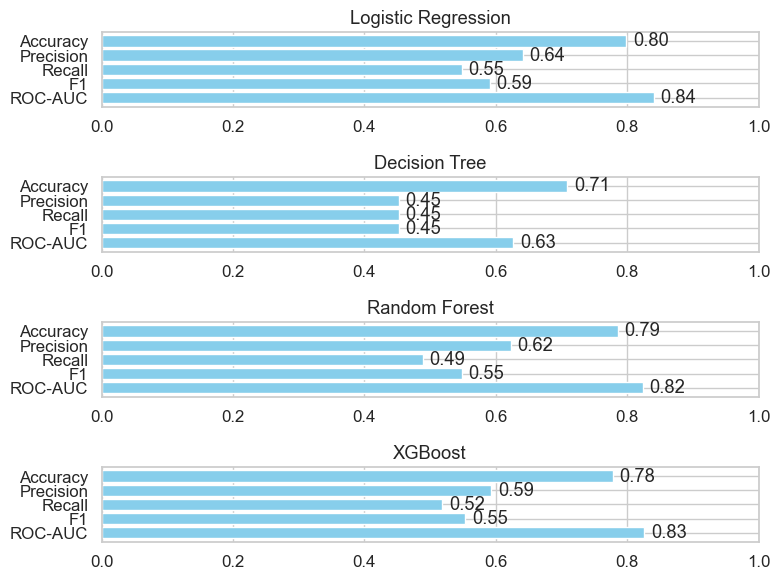

In [112]:
import matplotlib.pyplot as plt
import numpy as np

metrics = metrics_df.set_index("Model")

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*1.5))

for i, (model, row) in enumerate(metrics.iterrows()):
    axes[i].barh(row.index, row.values, color='skyblue')
    axes[i].set_xlim(0, 1)
    axes[i].set_title(model)
    for j, val in enumerate(row.values):
        axes[i].text(val + 0.01, j, f"{val:.2f}", va='center')
    axes[i].invert_yaxis()  # largest metric on top

plt.tight_layout()
plt.show()


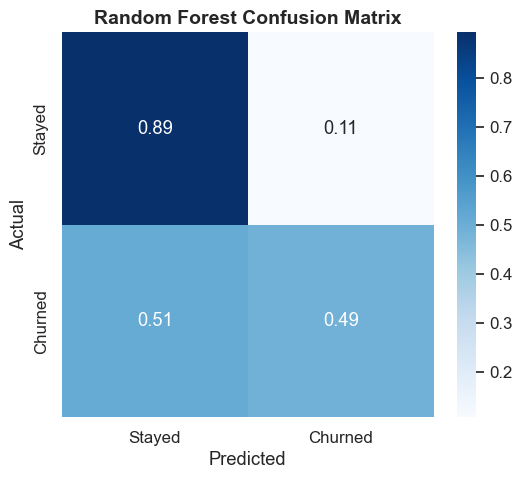

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_preds["Random Forest"])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Stayed", "Churned"], yticklabels=["Stayed", "Churned"])
plt.title("Random Forest Confusion Matrix", fontsize=14, weight="bold")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()